In [1]:
%matplotlib inline
import numpy as np
from pylab import *
import pandas as pd
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.utils import resample
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,auc,roc_auc_score,roc_curve,auc,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings(action='ignore')

In [22]:
# Load features
df = pd.read_excel(r"D:\Desktop\Cystadenoma\提取的特征\Three_Cystadenoma_features.xlsx")
target=df.iloc[:,2:3]
features=df.iloc[:,5:105]
features_names=list(features.columns)
# Feature normalization
scaler = StandardScaler()
X_data_1 = pd.DataFrame(scaler.fit_transform(features),columns=features_names,index=df.index)
y_data_1 = target
# Split into training and external validation sets
X_train, X_test, y_train, y_test = train_test_split(X_data_1, y_data_1, test_size=0.3,random_state=5)

In [6]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

clf = RandomForestClassifier(criterion='gini', random_state=1,n_jobs=-1,class_weight="balanced")
estimator = ([("clf", clf)])
pipeline = Mypipeline(estimator)

rfecv = RFECV(pipeline, step=1, scoring='accuracy',cv=5)   
rfecv.fit(X_train, y_train)

names = list(X_train.columns[rfecv.support_])
print('Features selected by RFECV with RF:', names)
print('Number of features selected by RFECV with RF:' , rfecv.n_features_) 
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
print("Grid_Score: %f" % (g_scores[indices[0]]))
select_train = X_train.loc[:, names]
select_test=X_test.loc[:, names]

Features selected by RFECV with RF: ['firstorder_10Percentile', 'firstorder_90Percentile', 'firstorder_Entropy', 'firstorder_Kurtosis', 'firstorder_Mean', 'firstorder_Median', 'firstorder_RootMeanSquared', 'firstorder_Uniformity', 'glcm_ClusterTendency', 'glcm_Idmn', 'glcm_Idn', 'glcm_MaximumProbability', 'glcm_SumEntropy', 'gldm_DependenceEntropy', 'gldm_SmallDependenceLowGrayLevelEmphasis', 'glszm_SmallAreaEmphasis', 'shape_Sphericity', 'shape_SurfaceVolumeRatio']
Number of features selected by RFECV with RF: 18
Grid_Score:  0.651429


In [7]:
# Grid search best RF model

clf = RandomForestClassifier(criterion='gini', random_state=1,n_jobs=-1,class_weight="balanced")
params = {'clf__criterion' : ['gini'],
          'clf__max_features' : ["auto", "sqrt", "log2"],
          'clf__max_depth': [3,4,5],
          'clf__min_samples_leaf' : [4,5,6],
          'clf__min_samples_split' : [1,2,3],
          'clf__n_estimators': [11,12,13]}
grid_search = GridSearchCV(pipeline,                         
                           param_grid=params, 
                            cv=5, 
                            scoring='accuracy', 
                            n_jobs=-1)

grid_search.fit(select_train, y_train)

# Validation on the external test set using the best RF model
clf = grid_search.best_estimator_
clf.fit(select_train, y_train)  
y_pred = clf.predict(select_test)
proba = clf.predict_proba(select_test)
y_test_oh = label_binarize(y_test, classes=[0,1,2])

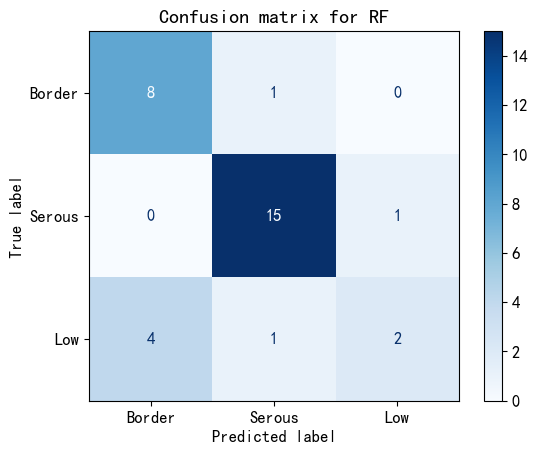

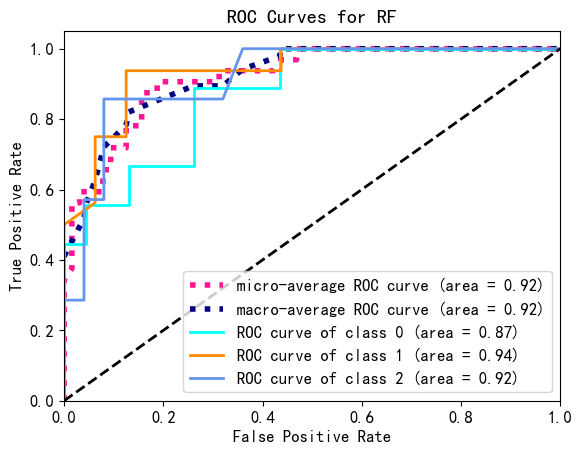

In [26]:
# Plot the results of the external validation set

# Plotting the confusion matrix
class_names=['Border','Serous','Low']
a=confusion_matrix(y_test,y_pred)   
mpl.rcParams['font.sans-serif'] = ['SimHei'] 
mpl.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=a,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.title('Confusion matrix for RF')
plt.show()     

# Plotting the multi-class ROC curve
n_classes = y_test_oh.shape[1]

fpr = dict()     # Calculate the ROC for each class
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_oh[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_oh.ravel(), proba.ravel())   # Compute micro-average ROC curve and ROC area
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))      # Compute macro-average ROC curve and ROC area
mean_tpr = np.zeros_like(all_fpr)      # Then interpolate all ROC curves at this points

for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes      # Finally average it and compute AUC
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2    # Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for RF')
plt.legend(loc="lower right")
plt.show()


In [29]:
# Calculate the classification metrics, including their 95% confidence intervals, for the best RF model on the external validation set

# Calculate AUC value and 95% confidence interval
def compute_macro_auc(fprs, tprs):      # Define a function to calculate AUC
    all_fpr = np.unique(np.concatenate(fprs))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(fprs)):
        mean_tpr += np.interp(all_fpr, fprs[i], tprs[i])
    mean_tpr /= len(fprs)
    return auc(all_fpr, mean_tpr)

def bootstrap_macro_auc(y_test_oh, proba, n_bootstrap_samples=1000):  
    macro_aucs = []
    n_classes = y_test_oh.shape[1]
    for _ in range(n_bootstrap_samples):   
        sample_indices = resample(np.arange(len(y_test_oh)))
        y_sample = y_test_oh[sample_indices]
        proba_sample = proba[sample_indices]
        
        fprs = []   
        tprs = []
        for i in range(n_classes):
            if np.sum(y_sample[:, i] == 1) > 0 and np.sum(y_sample[:, i] == 0) > 0:  # Check if both positive and negative samples exist
                fpr, tpr, _ = roc_curve(y_sample[:, i], proba_sample[:, i])
                fprs.append(fpr)
                tprs.append(tpr)

        if len(fprs) > 0:  # Calculate AUC only if there are valid ROC curves
            macro_auc = compute_macro_auc(fprs, tprs)
            macro_aucs.append(macro_auc)
    
    lower_percentile = 2.5      
    upper_percentile = 97.5
    lower_bound = np.percentile(macro_aucs, lower_percentile)
    upper_bound = np.percentile(macro_aucs, upper_percentile)

    fprs_orig = []    
    tprs_orig = []
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_oh[:, i], proba[:, i])
        fprs_orig.append(fpr)
        tprs_orig.append(tpr)
    macro_auc_orig = compute_macro_auc(fprs_orig, tprs_orig)
    
    return lower_bound, upper_bound, macro_auc_orig

# Calculate the values and 95% confidence intervals of each classification indicator
def calculate_confidence_interval(metric_scores):
    mean_score = np.mean(metric_scores)
    std_score = np.std(metric_scores)

    lower_bound = mean_score - 1.96 * std_score / np.sqrt(len(metric_scores))
    upper_bound = mean_score + 1.96 * std_score / np.sqrt(len(metric_scores))
    return mean_score, lower_bound, upper_bound

accuracy = accuracy_score(y_test, y_pred)    # Get metrics on external validation set
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

num_bootstrap_samples = 1000    # Obtaining confidence intervals by bootstrapping
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for _ in range(num_bootstrap_samples):
    indices = np.random.choice(len(y_pred), len(y_pred), replace=True)   # Generating bootstrap samples through sampling with replacement
    y_test_bootstrap = np.array(y_test)[indices]
    y_pred_bootstrap = np.array(y_pred)[indices]
    
    accuracy_scores.append(accuracy_score(y_test_bootstrap, y_pred_bootstrap))   # Calculate indicators and store
    precision_scores.append(precision_score(y_test_bootstrap, y_pred_bootstrap, average='macro'))
    recall_scores.append(recall_score(y_test_bootstrap, y_pred_bootstrap, average='macro'))
    f1_scores.append(f1_score(y_test_bootstrap, y_pred_bootstrap, average='macro'))

accuracy_mean, accuracy_lower, accuracy_upper = calculate_confidence_interval(accuracy_scores)  # Get the 95% confidence interval of the value of each indicator
precision_mean, precision_lower, precision_upper = calculate_confidence_interval(precision_scores)
recall_mean, recall_lower, recall_upper = calculate_confidence_interval(recall_scores)
f1_mean, f1_lower, f1_upper = calculate_confidence_interval(f1_scores)
lower_bound, upper_bound, macro_auc_orig = bootstrap_macro_auc(y_test_oh, proba)

result_dict = {    # Store results as DataFrame
    'Metric': ['Accuracy', 'AUC', 'F1-score', 'Precision', 'Sensitivity'],
    'Mean': [accuracy_mean, macro_auc_orig, f1_mean, precision_mean, recall_mean],
    '95% CI': [f"[{accuracy_lower:.4f}-{accuracy_upper:.4f}]",
               f"[{lower_bound:.4f}-{upper_bound:.4f}]",
               f"[{f1_lower:.4f}-{f1_upper:.4f}]",
               f"[{precision_lower:.4f}-{precision_upper:.4f}]",
               f"[{recall_lower:.4f}-{recall_upper:.4f}]"]
}

result = pd.DataFrame(result_dict, index=['Accuracy', 'AUC', 'F1-score', 'Precision', 'Sensitivity'])
result

,Metric,Mean,95% CI
Accuracy,Accuracy,0.776687,[0.7722-0.7812]
AUC,AUC,0.920177,[0.8369-0.9761]
F1-score,F1-score,0.675973,[0.6706-0.6813]
Precision,Precision,0.733028,[0.7258-0.7402]
Sensitivity,Sensitivity,0.703157,[0.6988-0.7075]


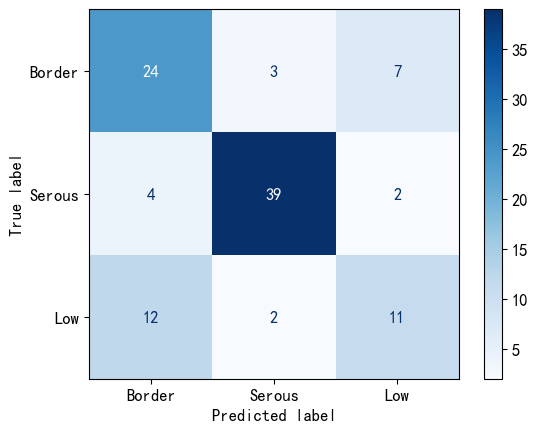

,Accuracy,Auc,Precision,Recall,F1-score
RF-Internal Validation,0.71±0.03,0.84±0.03,0.71±0.05,0.67±0.03,0.67±0.03


In [31]:
# The average result of five-fold cross-validation on the internal validation set of RF

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
aucs=[]
accs=[]
pres=[]
recs=[]
f1s=[]
cons=np.zeros((3, 3))
for train_index, test_index in cv.split(X_data_1, y_data_1): 
    X_train = X_data_1.iloc[train_index] 
    y_train = y_data_1.iloc[train_index] 
    X_test = X_data_1.iloc[test_index]
    y_test = y_data_1.iloc[test_index]
        
    clf.fit(X_train, y_train)  
    y_pred = clf.predict(X_test)
    proba = clf.predict_proba(X_test)
    y_test_oh = label_binarize(y_test, classes=[0,1,2])
    confusion_matrix(y_test, y_pred)
    
    aucs.append(roc_auc_score(y_test_oh, proba, multi_class='ovo', average='macro'))
    accs.append(accuracy_score(y_test, y_pred))
    pres.append(precision_score(y_test, y_pred,average='macro'))
    recs.append(recall_score(y_test, y_pred,average='macro'))
    f1s.append(f1_score(y_test, y_pred,average='macro'))
            
    class_names=['Border','Serous','Low']
    a=confusion_matrix(y_test,y_pred)
    cons=cons+a
    
mpl.rcParams['font.sans-serif'] = ['SimHei']   # Confusion matrix 
mpl.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cons,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 

result_dict = {'Accuracy': ['±'.join([str(round(np.mean(accs),2)),str(round(np.std(accs),2))])], 
                'Auc': ['±'.join([str(round(np.mean(aucs),2)),str(round(np.std(aucs),2))])], 
                'Precision': ['±'.join([str(round(np.mean(pres),2)),str(round(np.std(pres),2))])], 
                'Recall': ['±'.join([str(round(np.mean(recs),2)),str(round(np.std(recs),2))])], 
                'F1-score': ['±'.join([str(round(np.mean(f1s),2)),str(round(np.std(f1s),2))])]
                }
result = pd.DataFrame(result_dict, index=['RF-Internal Validation'])
result

In [22]:
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn import tree
# Loop to print each tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'  
class_name=['Border','Serous','Low']
for idx, estimator in enumerate(clf.estimators_):
    # Export dot file
    export_graphviz(estimator,
                    out_file='tree{}.dot'.format(idx),
                    feature_names=names,
                    class_names=class_name,
                    rounded=True,
                    proportion=False,
                    precision=2,
                    filled=True)
    # Convert to png file
    os.system('dot -Tpng tree{}.dot -o tree{}.png'.format(idx, idx))

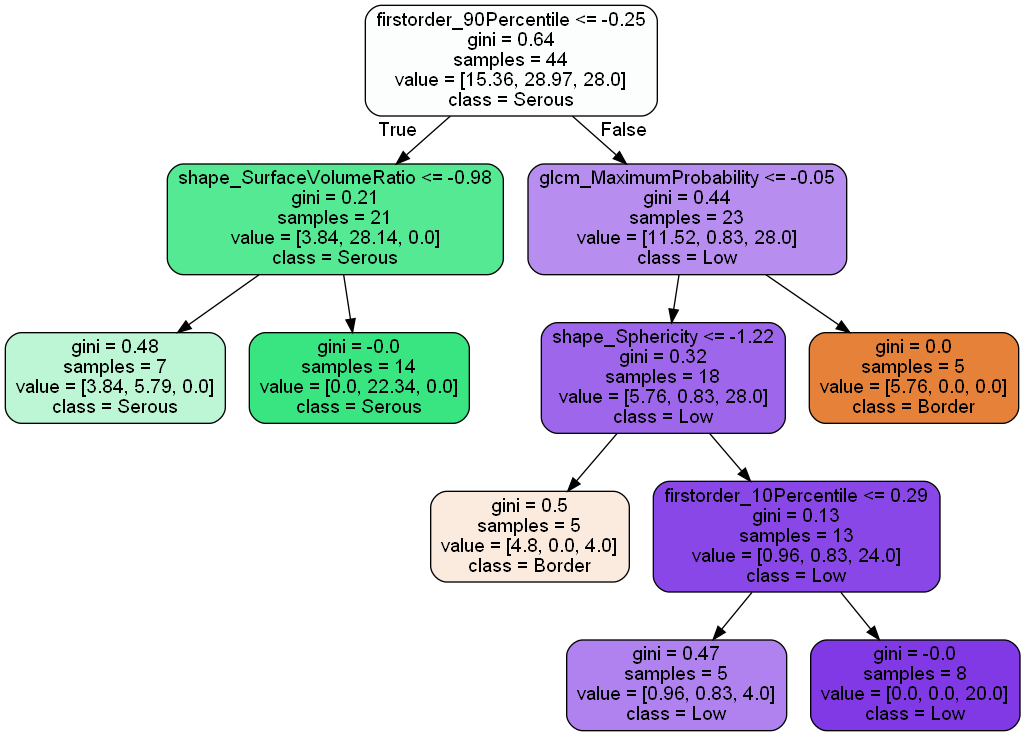

In [23]:
Image(filename = 'tree0.png')  

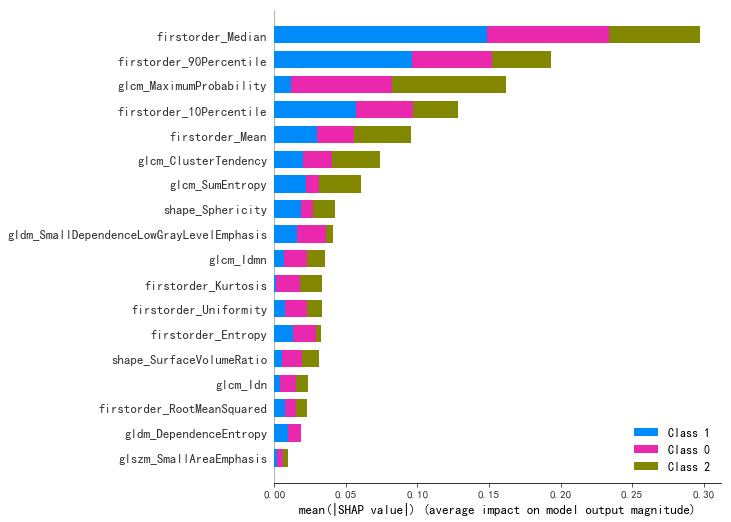

In [24]:
import shap
from shap.plots import _waterfall
explainer = shap.Explainer(clf)
shap_values1 = explainer.shap_values(select_test)
shap.summary_plot(shap_values1, select_test)

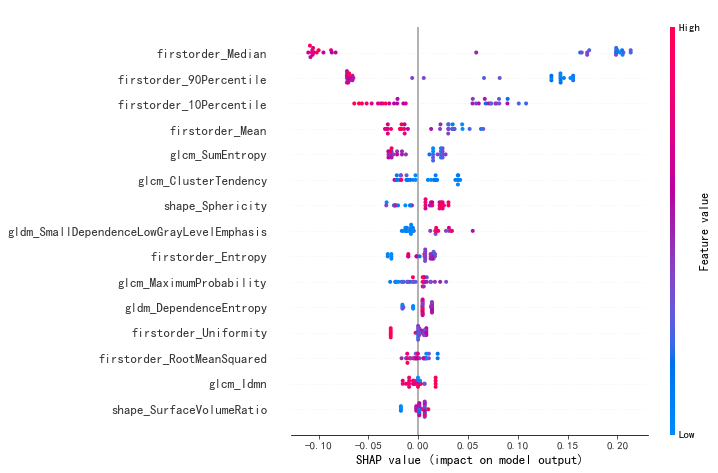

In [25]:
shap.summary_plot(shap_values1[1], select_test, max_display=15)

In [26]:
shap.force_plot(explainer.expected_value[1], shap_values1[1][0,:], select_test.iloc[0,:])